## Export decays from cytoplasm, nucleus and VLS

In [1]:
# 1. Import all required libraries
import pylab as plt
import tttrlib
from skimage import io
import numpy as np
from scipy import signal

## Load data

In [2]:
# Data
filename = './FLIM/mGBP_DA.ht3'
data = tttrlib.TTTR(filename, 'HT3')

# IRF (only for plotting)
filename_irf = './FLIM/mGBP_IRF.ht3'
irf = tttrlib.TTTR(filename_irf)

## Read the image

In [3]:
# Constructs a container for CLSM images
clsm_image = tttrlib.CLSMImage(tttr_data=data)

# Define used channels
green_ch = [0, 1]

# Fill the CLSM image container
clsm_image.fill(data, channels=green_ch)  # green channels

## Generate decays for whole image

In [4]:
n_frames, n_lines, n_pixel = clsm_image.shape
pseudo_mask = np.ones((n_frames, n_lines, n_pixel), dtype=np.uint8)
kw = {
    "tttr_data": data,
    "mask": pseudo_mask,
    "tac_coarsening": 8,  # Binning of the microtime, 8x binning = 16 ps resolution
    "stack_frames": True
}
decay_all = clsm_image.get_decay_of_pixels(**kw)
sum_decay_all = decay_all.sum(axis=0)

## Load masks

In [5]:
cytoplasm_mask = io.imread('./FLIM/mGBP_DA.ht3_sum.tif_wo nucleus_vesicles.tif').astype(np.uint8)
VLS_mask = io.imread('./FLIM/mGBP_DA.ht3_sum.tif_binary_vesicles.tif').astype(np.uint8)

# Caution: for nucleus only single average image mask was generated
# "multiply" 400x to have a mask for each frame
nucleus_mask_template = io.imread('./FLIM/mGBP_DA.ht3_sum.tif_avg_nucleus.tif').astype(np.uint8)
nucleus_mask = np.empty((n_frames, n_lines, n_pixel), dtype=np.uint8)
for i in range(n_frames):
    nucleus_mask[i] = nucleus_mask_template

## Generate decays from ROIs

In [6]:
kw_cytoplasm = {
    "tttr_data": data,
    "mask": cytoplasm_mask,
    "tac_coarsening": 8,
    "stack_frames": True
}
decay_cytoplasm = clsm_image.get_decay_of_pixels(**kw_cytoplasm)
sum_decay_cytoplasm = decay_cytoplasm.sum(axis=0)

kw_VLS = {
    "tttr_data": data,
    "mask": VLS_mask,
    "tac_coarsening": 8,
    "stack_frames": True
}
decay_VLS = clsm_image.get_decay_of_pixels(**kw_VLS)
sum_decay_VLS = decay_VLS.sum(axis=0)

kw_nucleus = {
    "tttr_data": data,
    "mask": nucleus_mask,
    "tac_coarsening": 8,
    "stack_frames": True
}
decay_nucleus = clsm_image.get_decay_of_pixels(**kw_nucleus)
sum_decay_nucleus = decay_nucleus.sum(axis=0)

## Generate IRF histogram

In [7]:
green_irf_indices = np.array(irf.get_selection_by_channel(green_ch))
micro_times = irf.micro_times
green_irf = micro_times[green_irf_indices]
green_irf_counts = np.bincount(green_irf // 8) # 8 = TAC coarsening of FLIM images

# Subtract background from IRF
bg_irf = np.mean(green_irf_counts[400:1200])
green_irf_bg = np.where(green_irf_counts > bg_irf, green_irf_counts - bg_irf, 0)

## Plot the donor fluorescence intensity decays

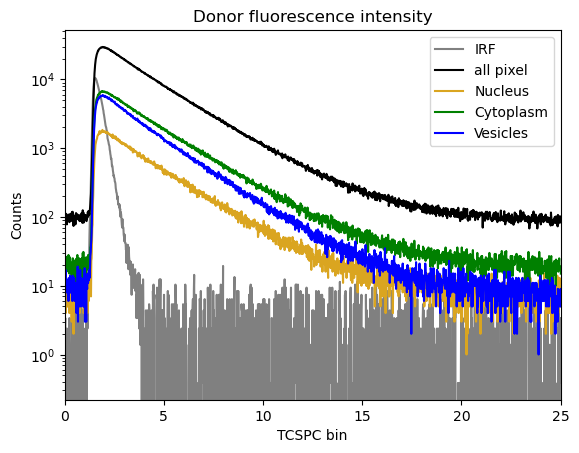

In [8]:
# Generate a time axis
dt = 0.016  # 16 ps microtime resolution due to 8x binning

x_values = np.arange(0,3124, 1)  # 3124 time channels after 8x binning
time_axis = x_values * dt

fig, ax = plt.subplots()
ax.semilogy(time_axis, green_irf_bg[0:3124], label='IRF', color='gray')
ax.semilogy(time_axis, sum_decay_all[0:3124], label='all pixel', color='black')
ax.semilogy(time_axis, sum_decay_nucleus[0:3124], label='Nucleus', color='goldenrod')
ax.semilogy(time_axis, sum_decay_cytoplasm[0:3124], label='Cytoplasm', color='green')
ax.semilogy(time_axis, sum_decay_VLS[0:3124], label='Vesicles', color='blue')
ax.legend()
ax.set(xlabel='Time [ns]', ylabel='Counts', title='Donor fluorescence intensity')
ax.set_xlim(0, 25)  # Show only the prompt time range
plt.show()

## Save the intensity decays

In [9]:
irf_decay = filename_irf + '_decay.txt'
np.savetxt(irf_decay, np.vstack([time_axis, green_irf_bg[0:3124]]).T)

all_pixel = filename + '_minPhot=20.txt'
np.savetxt(all_pixel, np.vstack([time_axis, sum_decay_all[0:3124]]).T)

cytoplasm = filename + '_cytoplasm.txt'
np.savetxt(cytoplasm, np.vstack([time_axis, sum_decay_cytoplasm[0:3124]]).T)

nucleus = filename + '_nucleus.txt'
np.savetxt(nucleus, np.vstack([time_axis, sum_decay_nucleus[0:3124]]).T)

VLS = filename + '_VLS.txt'
np.savetxt(VLS, np.vstack([time_axis, sum_decay_VLS[0:3124]]).T)

## Extracting the FRET-induced donor decay

### Load the donor reference sample

To extract the FRET-induced donor decay, a reference sample is required, which defines the fluorescence lifetime distribution in the absence of FRET. 

In [10]:
filename_DO = './Data/mGBP_DO.ht3'
data_DO = tttrlib.TTTR(filename_DO, 'HT3')

# Read image
clsm_image_DO = tttrlib.CLSMImage(tttr_data=data_DO)
# Fills the CLSM image container
clsm_image_DO.fill(data_DO, channels=green_ch)  # green channels

# Load the Donor-only mask
# Caution: for only single average image mask was generated
# "multiply" 400x to have a mask for each frame
DO_mask_template = io.imread('./FLIM/mGBP_DO_green_mask.tif').astype(np.uint8)

n_frames_DO, n_lines_DO, n_pixel_DO = clsm_image_DO.shape
DO_mask = np.empty((n_frames_DO, n_lines_DO, n_pixel_DO), dtype=np.uint8)
for i in range(n_frames_DO):
    DO_mask[i] = DO_mask_template
    
kw_DO = {
    "tttr_data": data_DO,
    "mask": DO_mask,
    "tac_coarsening": 8,
    "stack_frames": True
}

decay_DO = clsm_image_DO.get_decay_of_pixels(**kw_DO)
sum_decay_DO = decay_DO.sum(axis=0)

# save results as txt files
decay_DO = filename_DO + 'decay.txt'
np.savetxt(decay_DO, np.vstack([time_axis, sum_decay_DO[0:3124]]).T)

# Prepare the donor reference
bg_decay_DO = np.mean(sum_decay_DO[1:75])
sum_decay_bg_DO = np.where(sum_decay_DO > bg_decay_DO, sum_decay_DO - bg_decay_DO, 1)
sum_decay_DO_norm = sum_decay_bg_DO/max(sum_decay_bg_DO)

### Calculate the FRET-induced donor decay

In [11]:
def get_et(sum_decay_cytoplasm, sum_decay_bg_DO, dt):
    # Calculate background decay for DA
    bg_decay_DA = np.mean(sum_decay_cytoplasm[0:75])
    # Subtract background from decay signal
    sum_decay_bg_DA = np.where(sum_decay_cytoplasm > bg_decay_DA, sum_decay_cytoplasm - bg_decay_DA, 1)
    # Normalize the decay signal
    sum_decay_norm_DA = sum_decay_bg_DA / np.max(sum_decay_bg_DA)
    # Find the maximum intensity and its index
    max_int_DA = np.max(sum_decay_bg_DA)
    max_index_DA = np.min(np.where(sum_decay_bg_DA == max_int_DA))
    # Select the decay signal range
    selected_range_DA = sum_decay_bg_DA[max_index_DA:1250]
    # Create the time axis
    time_axis_DA = np.arange(0, len(selected_range_DA)) * dt
    # Calculate normalized et
    et = sum_decay_bg_DA / sum_decay_bg_DO
    et_norm = et / et[max_index_DA]
    # Select the normalized et range
    selected_et = et_norm[max_index_DA:900]

    return  selected_et

In [12]:
et_cytoplasm = get_et(sum_decay_cytoplasm, sum_decay_bg_DO, dt)
et_nucleus = get_et(sum_decay_nucleus, sum_decay_bg_DO, dt)
et_VLS = get_et(sum_decay_VLS, sum_decay_bg_DO, dt)

# Smooth the noisy data
# 100 = window size used for filtering, 5 = order of fitted polynomial
et_cytoplasm_smooth = signal.savgol_filter(et_cytoplasm, 150, 3)
et_nucleus_smooth = signal.savgol_filter(et_nucleus, 150, 3)
et_VLS_smooth = signal.savgol_filter(et_VLS, 150, 3)

### Plot the FRET-induced donor decay

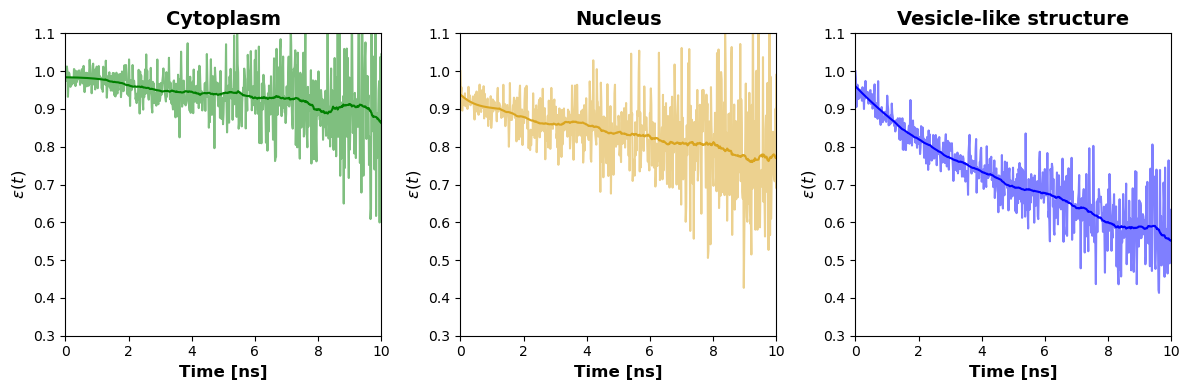

In [13]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(12,4))

ax[0].set_xlabel('Time [ns]', fontsize=12,  fontweight='bold')
ax[0].set_ylabel('$\epsilon(t)$', fontsize=12,  fontweight='bold')
ax[0].set(ylim=(0.3, 1.1), xlim=(0, 10))
ax[0].plot(time_axis[0:len(et_cytoplasm)], et_cytoplasm, color='green', alpha=0.5)
ax[0].plot(time_axis[0:len(et_cytoplasm)], et_cytoplasm_smooth, color='green')

ax[1].set_xlabel('Time [ns]', fontsize=12,  fontweight='bold')
ax[1].set_ylabel('$\epsilon(t)$', fontsize=12,  fontweight='bold')
ax[1].set(ylim=(0.3, 1.1), xlim=(0, 10))
ax[1].plot(time_axis[0:len(et_nucleus)], et_nucleus, color='goldenrod', alpha=0.5)
ax[1].plot(time_axis[0:len(et_nucleus)], et_nucleus_smooth, color='goldenrod')

ax[2].set_xlabel('Time [ns]', fontsize=12,  fontweight='bold')
ax[2].set_ylabel('$\epsilon(t)$', fontsize=12,  fontweight='bold')
ax[2].set(ylim=(0.3, 1.1), xlim=(0, 10))
ax[2].plot(time_axis[0:len(et_VLS)], et_VLS, color='blue', alpha=0.5)
ax[2].plot(time_axis[0:len(et_VLS)], et_VLS_smooth, color='blue')

ax[0].set_title('Cytoplasm', fontsize=14,  fontweight='bold')
ax[1].set_title('Nucleus', fontsize=14,  fontweight='bold')
ax[2].set_title('Vesicle-like structure', fontsize=14,  fontweight='bold')

plt.tight_layout()
plt.show()

### Save the results

In [14]:
et_cytoplasm_file = filename + '_et_cytoplasm.txt'
np.savetxt(et_cytoplasm_file, np.vstack([time_axis[0:len(et_cytoplasm)], et_cytoplasm]).T)

et_nucleus_file = filename + '_et_nucleus.txt'
np.savetxt(et_nucleus_file, np.vstack([time_axis[0:len(et_nucleus)], et_nucleus]).T)

et_VLS_file = filename + '_et_VLS.txt'
np.savetxt(et_VLS_file, np.vstack([time_axis[0:len(et_VLS)], et_VLS]).T)